Goal: develop a RGB-Depth fusion architecture for semantic segmentation based on Fully Convolutional Network (FCN) .


- Imports go here

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [ ]:
!gdown --id 1CPlnbHVdsTZn6eHDmw6Ci9mNAhugZxwf -O /tmp/fcnn-dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CPlnbHVdsTZn6eHDmw6Ci9mNAhugZxwf
From (redirected): https://drive.google.com/uc?id=1CPlnbHVdsTZn6eHDmw6Ci9mNAhugZxwf&confirm=t&uuid=19726a84-fbe3-49dd-859f-806e276abdd0
To: /tmp/fcnn-dataset.zip
100% 151M/151M [00:00<00:00, 226MB/s]


In [ ]:
local_zip = '/tmp/fcnn-dataset.zip'
import zipfile
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/fcnn')
zip_ref.close()

### Load the dataset and Ground-truth###

- Dataset consists of 1100 (per modality) images of road scenes. It is divided into train (600 images), test (200 images) and validation (300 images) datasets.
- Change the size of all images into 256*256.
- Converting the labels into one hot encoding
- Create a DataLoader for loading the files when training the model.

In [ ]:
class DataLoader(Sequence):
    def __init__(self, data_dir, num_samples, start_index, num_classes, batch_size, input_shape):
        self.data_dir = data_dir
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.start_index = start_index
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.indexes = np.arange(num_samples)

    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_rgb_files = [os.path.join(self.data_dir, 'rgb', f'{i + self.start_index}.npy') for i in batch_indexes]
        batch_depth_files = [os.path.join(self.data_dir, 'depth', f'{i + self.start_index}.npy') for i in batch_indexes]
        batch_label_files = [os.path.join(self.data_dir, 'label', f'{i + self.start_index}.npy') for i in batch_indexes]

        return self.__generate_data(batch_rgb_files, batch_depth_files, batch_label_files)

    def __generate_data(self, batch_rgb_files, batch_depth_files, batch_label_files):
        batch_rgb = np.zeros((len(batch_rgb_files), *self.input_shape))
        batch_depth = np.zeros((len(batch_depth_files), *self.input_shape))
        batch_label = np.zeros((len(batch_label_files), np.prod(self.input_shape[:2]), self.num_classes))

        for i, (rgb_file, depth_file, label_file) in enumerate(zip(batch_rgb_files, batch_depth_files, batch_label_files)):
            batch_rgb[i] = resize(np.load(rgb_file), self.input_shape, mode='edge', order=1, preserve_range=True)
            batch_depth[i] = np.repeat(resize(np.load(depth_file), (*self.input_shape[:2], 1), mode='edge', order=1, preserve_range=True), 3, axis=-1)

            batch_label[i] = to_categorical((np.floor(resize(np.load(label_file), self.input_shape[:2], mode='edge', order=1, preserve_range=True)).flatten()), num_classes=self.num_classes)

        return [batch_rgb, batch_depth], batch_label


num_classes = 19
batch_size = 12
input_shape = (256, 256, 3)
colors = sns.color_palette(None, num_classes)

train_data_dir = '/tmp/fcnn/dataset/train'
train_num_samples = 600
train_start_index = 0

validation_data_dir = '/tmp/fcnn/dataset/validation'
validation_num_samples = 100
validation_start_index = 200

test_data_dir = '/tmp/fcnn/dataset/test'
test_num_samples = 200
test_start_index = 0

# Create DataLoader instance
train_data_loader = DataLoader(train_data_dir, train_num_samples, train_start_index, num_classes, batch_size, input_shape)
validation_data_loader = DataLoader(validation_data_dir, validation_num_samples, validation_start_index, num_classes, batch_size, input_shape)
test_data_loader = DataLoader(test_data_dir, test_num_samples, test_start_index, num_classes, batch_size, input_shape)

- Visualize the data you have prepared

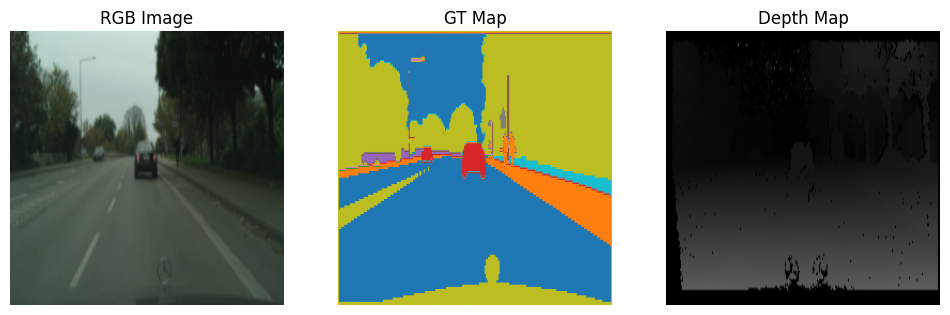

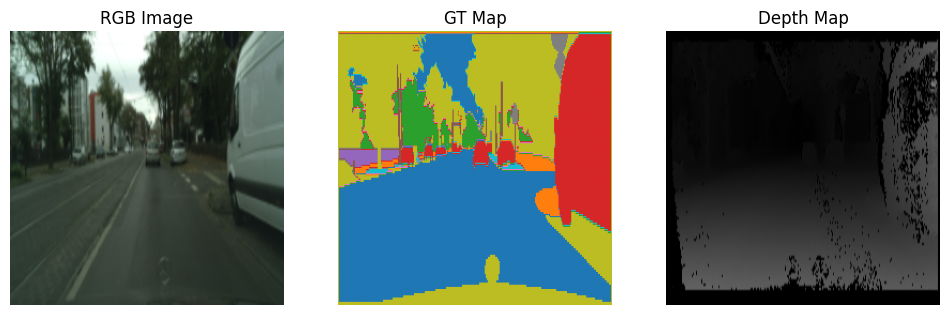

In [ ]:
random_indices = random.sample(range(len(train_data_loader)), 2)
# Iterate over the selected random indices
for idx in random_indices:
    # Get a random index for the sample within the batch
    sample_idx = random.randint(0, train_data_loader.batch_size - 1)

    # Get a single sample from the data loader
    batch_x, batch_y = train_data_loader[idx]
    sample_rgb, sample_depth = batch_x[0][sample_idx], batch_x[1][sample_idx]
    sample_label = batch_y[sample_idx]

    # Visualize the data
    plt.figure(figsize=(12, 4))

    # Plot RGB image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_rgb)
    plt.title('RGB Image')
    plt.axis('off')

    # Plot GT Map

    label_img = np.zeros( (256, 256, 3) ).astype('float')
    label_data = np.uint8(np.squeeze(np.argmax(sample_label, axis=-1)).reshape(256, 256))

    for i in range(256):
        for j in range(256):
            label_img[i, j] = colors[label_data[i,j]]

    plt.subplot(1, 3, 2)
    plt.imshow(label_img)
    plt.title('GT Map')
    plt.axis('off')

    # Plot depth Map
    plt.subplot(1, 3, 3)
    plt.imshow(sample_depth)
    plt.title('Depth Map')
    plt.axis('off')

    plt.show()

 Define a Fully Convolutional Network (FCN) for image segmentaion by fusing RGB and depth images. The network consists of  two sterams which each stream has following layers:

    1. Use the pretrained ResNet50 on imageNet
    2. Add two Conv layers with 128 and 256 nodes, respectively. Kernel size (3,3), stride (1,1)
    3. Top of the Conv layers, add dropout layer with 0.2
    4. Concatenate two streams.
    5. Add a transposed convolution layer (Conv2DTranspose)  with Kernel size (64,64), stride (32,32)
    6. Add a softmax activation layer
    
 You can find the model summary and structure in the PDF file.


In [ ]:
def create_fcn_model(input_shape, num_classes):
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet50_1 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    # resnet50.trainable = False

    pre_trained_model_rgb = Model(inputs=resnet50.input, outputs=resnet50.get_layer('conv5_block3_out').output, name='pre_trained_model_rgb')
    pre_trained_model_depth = Model(inputs=resnet50_1.input, outputs=resnet50_1.get_layer('conv5_block3_out').output, name='pre_trained_model_depth')


    # pre_trained_model_rgb.trainable = False
    # pre_trained_model_depth.trainable = False

    # Define input layers for RGB and depth images
    input_rgb = layers.Input(shape=input_shape)
    input_depth = layers.Input(shape=input_shape)

    pre_trained_features_rgb = pre_trained_model_rgb(input_rgb)
    pre_trained_features_depth = pre_trained_model_depth(input_depth)

    conv1_rgb = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(pre_trained_features_rgb)
    conv1_depth = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(pre_trained_features_depth)

    conv2_rgb = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv1_rgb)
    conv2_depth = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv1_depth)

    dropout_rgb = layers.Dropout(0.2)(conv2_rgb)
    dropout_depth = layers.Dropout(0.2)(conv2_depth)

    # Concatenate features from both streams
    concatenated_features = layers.Concatenate(axis=-1)([dropout_rgb, dropout_depth])

    # Transposed convolution layer
    transposed_conv = layers.Conv2DTranspose(num_classes, kernel_size=(64,64) ,  strides=(32,32) , use_bias=False, padding='same')(concatenated_features)

    # Reshape layer
    reshaped_output = layers.Reshape((-1, num_classes))(transposed_conv)

    # Softmax activation layer
    output = layers.Softmax()(reshaped_output)

    # Create model
    model = models.Model(inputs=[input_rgb, input_depth], outputs=output)

    return model

input_shape = (256, 256, 3)

# Create the model
fcn_model = create_fcn_model(input_shape, num_classes)

# Print model summary
fcn_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 pre_trained_model_rgb (Fun  (None, 8, 8, 2048)           2358771   ['input_3[0][0]']             
 ctional)                                                 2                                       
                                                                                                  
 pre_trained_model_depth (F  (None, 8, 8, 2048)           2358771   ['input_4[0][0]']       

Compile the model with SGD(learning_rate=0.01, decay=1e-5, momentum=0.9) and loss="categorical_crossentropy"

Train the model on the “train” dataset  and “validation”dataset for epochs =10.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-5, momentum=0.9)
loss = "categorical_crossentropy"

fcn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
epochs = 10

fcn_model.fit(train_data_loader, epochs=epochs, validation_data=validation_data_loader)
# Train the model

Epoch 1/30


50/50 [==============================] - 217s 4s/step - loss: 2.6095 - accuracy: 0.2726 - val_loss: 2.4519 - val_accuracy: 0.3767
Epoch 2/30
50/50 [==============================] - 197s 4s/step - loss: 1.4804 - accuracy: 0.5336 - val_loss: 2.3184 - val_accuracy: 0.2777
Epoch 3/30
50/50 [==============================] - 197s 4s/step - loss: 1.2029 - accuracy: 0.5816 - val_loss: 3.0599 - val_accuracy: 0.2121
Epoch 4/30
50/50 [==============================] - 208s 4s/step - loss: 1.0605 - accuracy: 0.6584 - val_loss: 2.9711 - val_accuracy: 0.2247
Epoch 5/30
50/50 [==============================] - 199s 4s/step - loss: 1.0018 - accuracy: 0.6831 - val_loss: 2.8262 - val_accuracy: 0.2201
Epoch 6/30
50/50 [==============================] - 197s 4s/step - loss: 0.9483 - accuracy: 0.7067 - val_loss: 2.7617 - val_accuracy: 0.2398
Epoch 7/30
50/50 [==============================] - 196s 4s/step - loss: 0.8845 - accuracy: 0.7313 - val_loss: 2.9259 - val_accuracy: 0.2437
Epoch 8/30


 Evaluate the model on the training and test dataset. The results must be shown as

- Print loss and accuracy of model for  test dataset.

- Predict semantically segmented images on 5 random example of test dataset.

- Visualize the 5 random examples alongside the ground truth and prediction.

17/17 [==============================] - 23s 1s/step - loss: 0.9310 - accuracy: 0.7373
Test Loss: 0.9309990406036377
Test Accuracy: 0.7372921109199524
1/1 [==============================] - 2s 2s/step


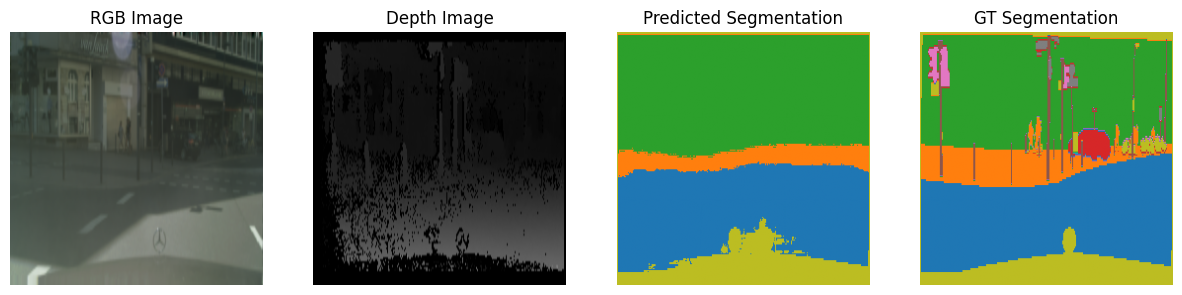

1/1 [==============================] - 0s 212ms/step


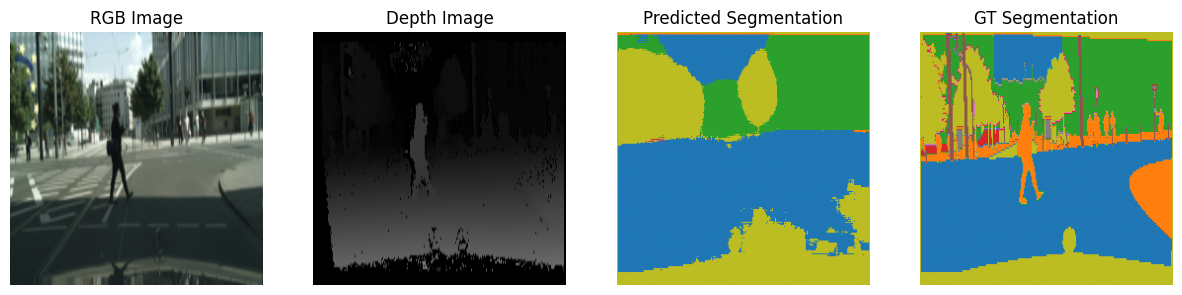

1/1 [==============================] - 0s 191ms/step


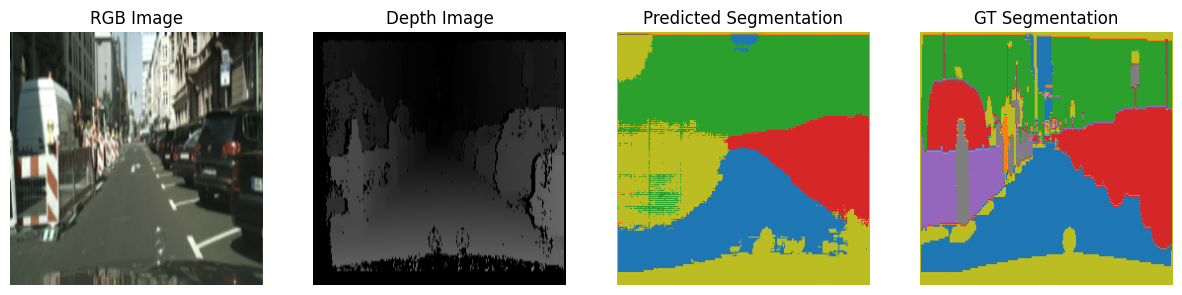

1/1 [==============================] - 0s 182ms/step


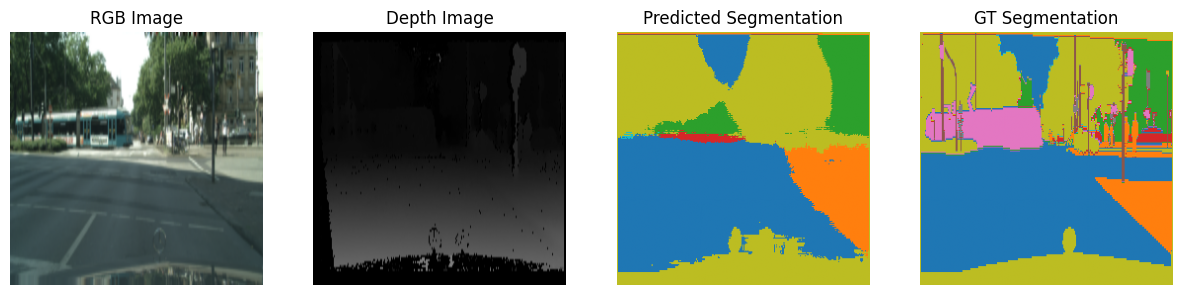

1/1 [==============================] - 0s 169ms/step


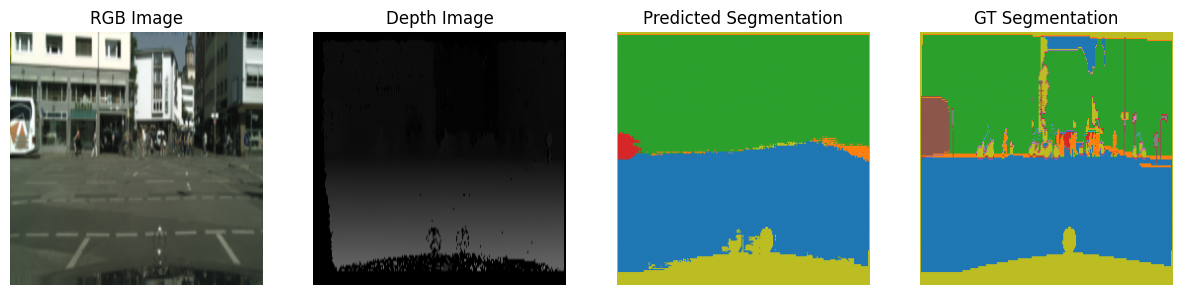

In [ ]:
test_loss, test_accuracy = fcn_model.evaluate(test_data_loader)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

random_indices = random.sample(range(len(test_data_loader)), 5)

# Iterate over the selected random indices
for idx in random_indices:
    # Get a random index for the sample within the batch
    sample_idx = random.randint(0, test_data_loader.batch_size - 1)

    # Get a single sample from the test dataset
    batch_x, batch_y = test_data_loader[idx]
    sample_rgb, sample_depth = batch_x[0][sample_idx], batch_x[1][sample_idx]
    sample_label = batch_y[sample_idx]

    # Predict the segmentation mask for the sample
    prediction = fcn_model.predict([np.expand_dims(sample_rgb, axis=0), np.expand_dims(sample_depth, axis=0)])

    # Plot the RGB image, ground truth, and prediction
    plt.figure(figsize=(15, 5))

    # Plot RGB image
    plt.subplot(1, 4, 1)
    plt.imshow(sample_rgb)
    plt.title('RGB Image')
    plt.axis('off')

    # Plot depth image
    plt.subplot(1, 4, 2)
    plt.imshow(sample_depth)
    plt.title('Depth Image')
    plt.axis('off')

    # Plot prediction
    pred__img = np.zeros( (256, 256, 3) ).astype('float')
    pred_data = np.uint8(np.squeeze(np.argmax(prediction, axis=-1)).reshape(256, 256))

    for i in range(256):
        for j in range(256):
            pred__img[i, j] = colors[pred_data[i,j]]

    plt.subplot(1, 4, 3)
    plt.imshow(pred__img)
    plt.title('Predicted Segmentation')
    plt.axis('off')

    # Plot ground truth

    label_data = np.uint8(np.squeeze(np.argmax(sample_label, axis=-1)).reshape(256, 256))
    label_img = np.zeros( (256, 256, 3) ).astype('float')

    for i in range(256):
        for j in range(256):
            label_img[i, j] = colors[label_data[i,j]]

    plt.subplot(1, 4, 4)
    plt.imshow(label_img)
    plt.title('GT Segmentation')
    plt.axis('off')

    plt.show()

Implement FCNs for each sing modality and compare their accuracy with fusion model. I need the result of the following table in the same notebook.

In [ ]:
def create_fcn_model_for_rgb(input_shape, num_classes):
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    input_rgb = layers.Input(shape=input_shape)
    input_depth = layers.Input(shape=input_shape)
    pre_trained_features_rgb = resnet50(input_rgb)
    conv1_rgb = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(pre_trained_features_rgb)
    conv2_rgb = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv1_rgb)
    dropout_rgb = layers.Dropout(0.2)(conv2_rgb)
    # Transposed convolution layer
    transposed_conv = layers.Conv2DTranspose(num_classes, kernel_size=(64,64) ,  strides=(32,32) , use_bias=False, padding='same')(dropout_rgb)
    # Reshape layer
    reshaped_output = layers.Reshape((-1, num_classes))(transposed_conv)
    # Softmax activation layer
    output = layers.Softmax()(reshaped_output)
    # Create model
    model = models.Model(inputs=[input_rgb, input_depth], outputs=output)
    return model

def create_fcn_model_for_depth(input_shape, num_classes):
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    input_rgb = layers.Input(shape=input_shape)
    input_depth = layers.Input(shape=input_shape)
    pre_trained_features_depth = resnet50(input_depth)
    conv1_depth = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(pre_trained_features_depth)
    conv2_depth = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv1_depth)
    dropout_depth = layers.Dropout(0.2)(conv2_depth)
    # Transposed convolution layer
    transposed_conv = layers.Conv2DTranspose(num_classes, kernel_size=(64,64) ,  strides=(32,32) , use_bias=False, padding='same')(dropout_depth)
    # Reshape layer
    reshaped_output = layers.Reshape((-1, num_classes))(transposed_conv)
    # Softmax activation layer
    output = layers.Softmax()(reshaped_output)
    # Create model
    model = models.Model(inputs=[input_rgb, input_depth], outputs=output)
    return model

fcn_model_rgb = create_fcn_model_for_rgb(input_shape, num_classes)
fcn_model_depth = create_fcn_model_for_depth(input_shape, num_classes)

rgb_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-5, momentum=0.9)
depth_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-5, momentum=0.9)

epochs = 10
loss = "categorical_crossentropy"

fcn_model_rgb.compile(optimizer=rgb_optimizer, loss=loss, metrics=['accuracy'])
fcn_model_depth.compile(optimizer=depth_optimizer, loss=loss, metrics=['accuracy'])

fcn_model_rgb.fit(train_data_loader, epochs=epochs, validation_data=validation_data_loader)
fcn_model_depth.fit(train_data_loader, epochs=epochs, validation_data=validation_data_loader)

Epoch 1/30


 1/50 [..............................] - ETA: 8:38 - loss: 2.9450 - accuracy: 0.0524

In [ ]:
rgb_test_loss, rgb_test_accuracy = fcn_model_rgb.evaluate(test_data_loader)
print("Rgb Test Loss:", rgb_test_loss)
print("Rgb Test Accuracy:", rgb_test_accuracy)

depth_test_loss, depth_test_accuracy = fcn_model_depth.evaluate(test_data_loader)
print("Depth Test Loss:", depth_test_loss)
print("Depth Test Accuracy:", depth_test_accuracy)

# RESULT

| **Modality** | **Test Accuracy(%)** |
| -------- | -------- |
| RGB only | 0.7204055190086365 |
| Depth Only | 0.6720829606056213 |
| RBB and Depth Fusion | 0.7372921109199524 |